Running solver... please wait
Steps: 3159


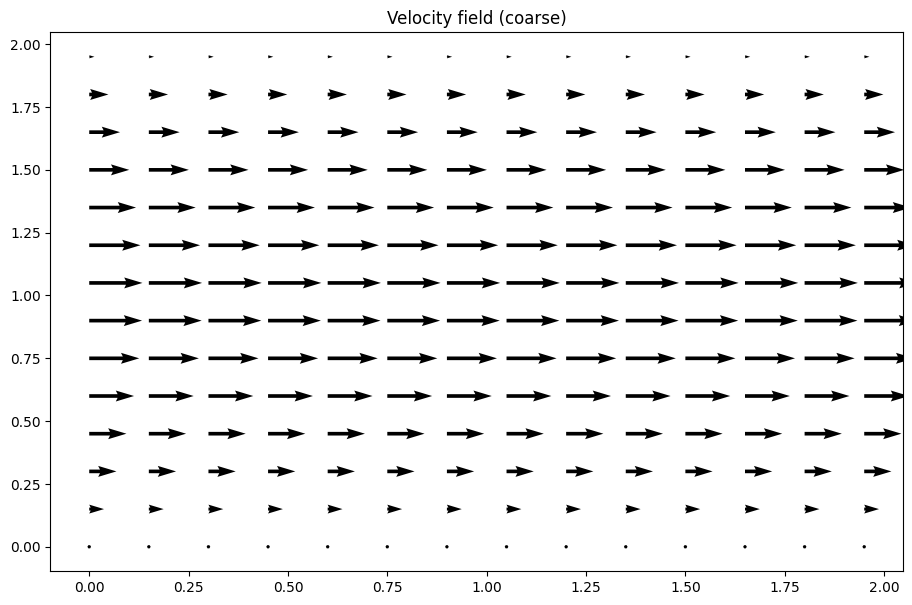

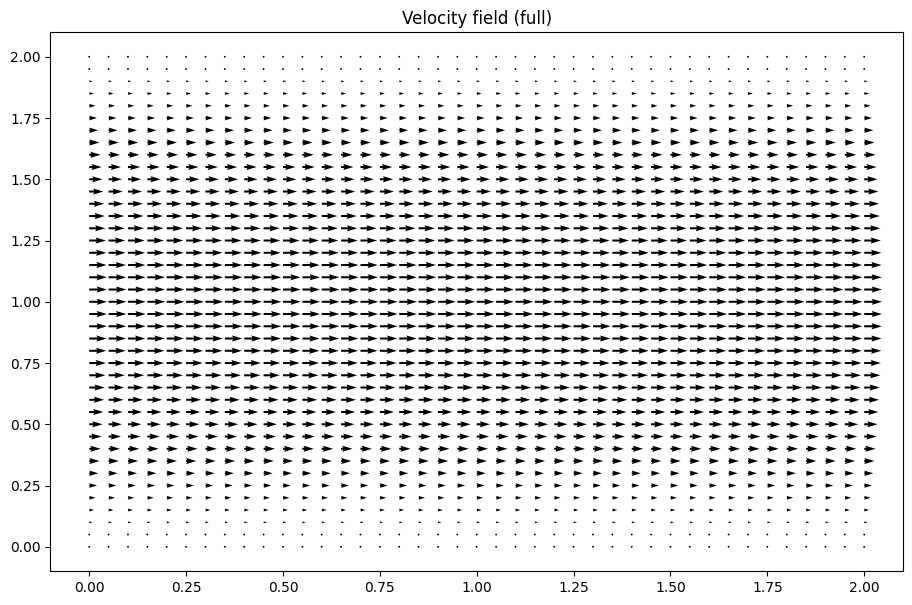

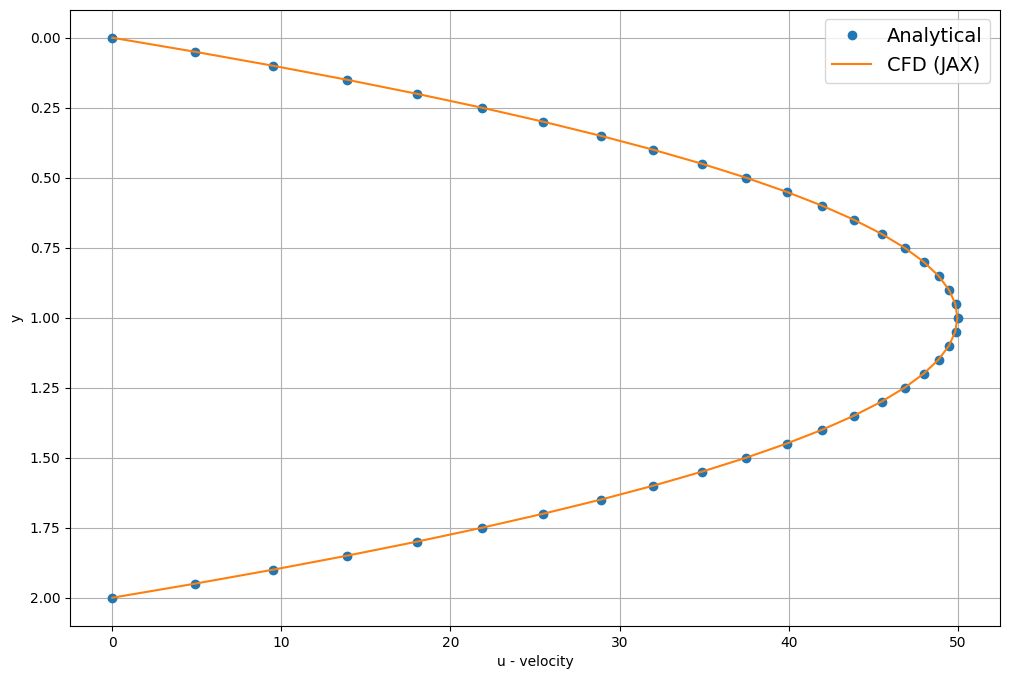

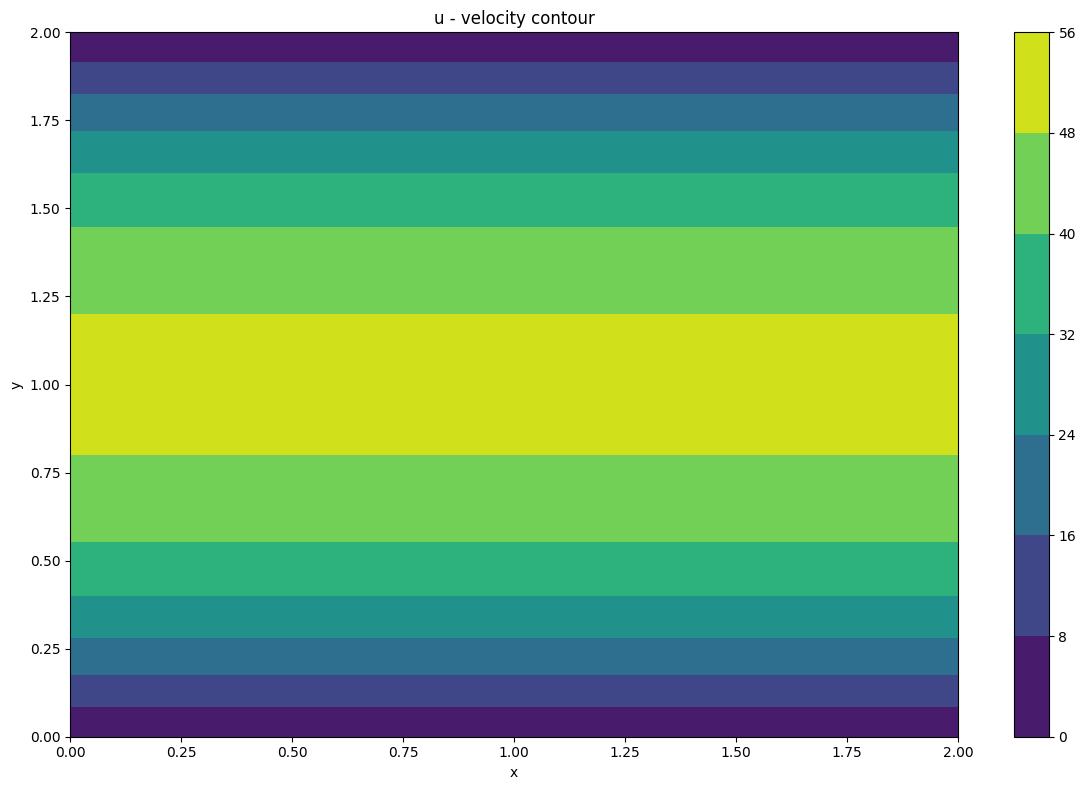

X-Velocity Error -> L2 Norm: 1.4765e-02, Max: 2.1140e-02, Min: 0.0000e+00


In [3]:
# JAX port of your 2D channel/Poiseuille-like solver with periodic x BCs

# Import JAX and configure it
import jax
jax.config.update("jax_enable_x64", True)           # use 64-bit floats for better precision
#jax.config.update("jax_platform_name", "cpu")       # run on CPU (change to "gpu" if available)

# Import JAX's numpy and tools
import jax.numpy as jnp
from jax import lax, jit

# Standard Python + plotting imports
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Helper kernels (JAX-friendly)
# ----------------------------

@jit
def build_up_b(rho, dt, dx, dy, u, v):
    """
    Builds the 'b' matrix used in the pressure Poisson equation.
    It represents how much pressure needs to change to enforce incompressibility.
    """
    b = jnp.zeros_like(u)  # start with zeros

    # Compute centered derivatives in the interior of the grid
    ux = (u[1:-1, 2:]   - u[1:-1, 0:-2]) / (2.0 * dx)  # du/dx
    vy = (v[2:,   1:-1] - v[0:-2, 1:-1]) / (2.0 * dy)  # dv/dy
    uy = (u[2:,   1:-1] - u[0:-2, 1:-1]) / (2.0 * dy)  # du/dy (for cross term)
    vx = (v[1:-1, 2:]   - v[1:-1, 0:-2]) / (2.0 * dx)  # dv/dx (for cross term)

    # combine all terms that make up the source of pressure change
    term1 = (1.0 / dt) * (ux + vy)
    term2 = ux**2
    term3 = 2.0 * (uy * vx)
    term4 = ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2.0 * dy))**2

    # put everything together in the interior region
    b = b.at[1:-1, 1:-1].set(rho * (term1 - term2 - term3 - term4))

    # --- Periodic boundary conditions in x-direction for b ---
    # This ensures that flow wraps around smoothly at left/right edges

    # Right edge (uses values from left edge)
    dudx_r = (u[1:-1, 0] - u[1:-1, -2]) / (2.0 * dx)
    dvdy_r = (v[2:,   -1] - v[0:-2, -1]) / (2.0 * dy)
    term2_r = dudx_r**2
    term3_r = 2.0 * ((u[2:, -1] - u[0:-2, -1]) / (2.0 * dy)) * ((v[1:-1, 0] - v[1:-1, -2]) / (2.0 * dx))
    term4_r = ((v[2:, -1] - v[0:-2, -1]) / (2.0 * dy))**2
    b = b.at[1:-1, -1].set(rho * ((1.0 / dt) * (dudx_r + dvdy_r) - term2_r - term3_r - term4_r))

    # Left edge (uses values from right edge)
    dudx_l = (u[1:-1, 1] - u[1:-1, -1]) / (2.0 * dx)
    dvdy_l = (v[2:, 0] - v[0:-2, 0]) / (2.0 * dy)
    term2_l = dudx_l**2
    term3_l = 2.0 * ((u[2:, 0] - u[0:-2, 0]) / (2.0 * dy)) * ((v[1:-1, 1] - v[1:-1, -1]) / (2.0 * dx))
    term4_l = ((v[2:, 0] - v[0:-2, 0]) / (2.0 * dy))**2
    b = b.at[1:-1, 0].set(rho * ((1.0 / dt) * (dudx_l + dvdy_l) - term2_l - term3_l - term4_l))

    return b


def pressure_poisson_periodic(p, b, dx, dy, nit):
    """
    Solves for the pressure field 'p' using Jacobi iterations.
    Handles periodic sides (x) and solid top/bottom (Neumann BCs).
    """
    dx2, dy2 = dx * dx, dy * dy
    denom = 2.0 * (dx2 + dy2)  # used to simplify formula

    # this function updates pressure repeatedly using lax.fori_loop (JAX compatible loop)
    def body(_, carry):
        p = carry
        pn = p  # a copy of p to use old values

        # Interior update
        p_new = p.at[1:-1, 1:-1].set(
            ((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy2 +
             (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx2) / denom
            - dx2 * dy2 / denom * b[1:-1, 1:-1]
        )

        # Right periodic edge (connects to left)
        p_new = p_new.at[1:-1, -1].set(
            ((pn[1:-1, 0] + pn[1:-1, -2]) * dy2 +
             (pn[2:, -1] + pn[0:-2, -1]) * dx2) / denom
            - dx2 * dy2 / denom * b[1:-1, -1]
        )

        # Left periodic edge (connects to right)
        p_new = p_new.at[1:-1, 0].set(
            ((pn[1:-1, 1] + pn[1:-1, -1]) * dy2 +
             (pn[2:, 0] + pn[0:-2, 0]) * dx2) / denom
            - dx2 * dy2 / denom * b[1:-1, 0]
        )

        # Neumann BCs (no pressure change across top and bottom)
        p_new = p_new.at[-1, :].set(p_new[-2, :])  # top wall
        p_new = p_new.at[0, :].set(p_new[1, :])    # bottom wall

        return p_new

    # Run the pressure solver for 'nit' iterations
    p = lax.fori_loop(0, nit, body, p)
    return p


# ----------------------------
# Problem setup
# ----------------------------

nx = 41
ny = 41
nit = 80
H = 2.0
dx = H / (nx - 1)
dy = H / (ny - 1)
x = np.linspace(0.0, H, nx)
y = np.linspace(0.0, H, ny)
X, Y = np.meshgrid(x, y)

rho = 2.0    # density
nu = 0.01    # kinematic viscosity
mu = nu * rho
F = 1.0      # body force (drives the flow)
dpdx = F * rho
dt = 0.1     # time step size

# start with all zeros (fluid at rest)
u0 = jnp.zeros((ny, nx))
v0 = jnp.zeros((ny, nx))
p0 = jnp.ones((ny, nx))  # start with uniform pressure

# ----------------------------
# One time step (JIT) - Part 2
# ----------------------------
@jit
def step_once(state):
    """
    Advance the solution by one time step.
    Updates velocity (u,v) and pressure (p) using finite differences.
    """
    print("Running solver... please wait")
    u, v, p = state  # unpack current fields

    # make local references to current fields (clearer names)
    un = u
    vn = v

    # build pressure source term and solve for new pressure
    b = build_up_b(rho, dt, dx, dy, u, v)          # how pressure should change
    p = pressure_poisson_periodic(p, b, dx, dy, nit)  # solve Poisson for pressure

    # ----------------------------
    # Update u (x-velocity) in the interior
    # ----------------------------
    u_new = u.at[1:-1, 1:-1].set(
        un[1:-1, 1:-1]  # start from previous u
        # convection (how u moves with the flow) in x
        - un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, 0:-2])
        # convection in y (how u changes due to v moving it)
        - vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[0:-2, 1:-1])
        # pressure gradient term (pushes fluid along pressure differences)
        - dt / (2.0 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2])
        # viscous diffusion (smooths velocity) in x and y
        + nu * (
            dt / dx**2 * (un[1:-1, 2:] - 2.0 * un[1:-1, 1:-1] + un[1:-1, 0:-2])
            + dt / dy**2 * (un[2:, 1:-1] - 2.0 * un[1:-1, 1:-1] + un[0:-2, 1:-1])
        )
        # body force (driving the flow), simple addition
        + F * dt
    )

    # ----------------------------
    # Update v (y-velocity) in the interior
    # ----------------------------
    v_new = v.at[1:-1, 1:-1].set(
        vn[1:-1, 1:-1]  # start from previous v
        # convection terms for v
        - un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2])
        - vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1])
        # pressure gradient pushing in y
        - dt / (2.0 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1])
        # viscous diffusion for v
        + nu * (
            dt / dx**2 * (vn[1:-1, 2:] - 2.0 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2])
            + dt / dy**2 * (vn[2:, 1:-1] - 2.0 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])
        )
    )

    # ----------------------------
    # Periodic BCs in x for u (right and left edges)
    # Note: indexing uses Python negative indices to wrap around
    # ----------------------------
    u_new = u_new.at[1:-1, -1].set(
        un[1:-1, -1]  # previous u at right edge
        - un[1:-1, -1] * dt / dx * (un[1:-1, -1] - un[1:-1, -2])  # convection x (right)
        - vn[1:-1, -1] * dt / dy * (un[1:-1, -1] - un[0:-2, -1])  # convection y
        - dt / (2.0 * rho * dx) * (p[1:-1, 0] - p[1:-1, -2])  # pressure uses wrapped neighbor p[*,0]
        + nu * (
            dt / dx**2 * (un[1:-1, 0] - 2.0 * un[1:-1, -1] + un[1:-1, -2])  # second deriv x wraps
            + dt / dy**2 * (un[2:, -1] - 2.0 * un[1:-1, -1] + un[0:-2, -1])
        )
        + F * dt
    )
    # left edge: uses right-side neighbor for wrap-around
    u_new = u_new.at[1:-1, 0].set(
        un[1:-1, 0]
        - un[1:-1, 0] * dt / dx * (un[1:-1, 0] - un[1:-1, -1])
        - vn[1:-1, 0] * dt / dy * (un[1:-1, 0] - un[0:-2, 0])
        - dt / (2.0 * rho * dx) * (p[1:-1, 1] - p[1:-1, -1])
        + nu * (
            dt / dx**2 * (un[1:-1, 1] - 2.0 * un[1:-1, 0] + un[1:-1, -1])
            + dt / dy**2 * (un[2:, 0] - 2.0 * un[1:-1, 0] + un[0:-2, 0])
        )
        + F * dt
    )

    # ----------------------------
    # Periodic BCs in x for v (right and left edges)
    # ----------------------------
    v_new = v_new.at[1:-1, -1].set(
        vn[1:-1, -1]
        - un[1:-1, -1] * dt / dx * (vn[1:-1, -1] - vn[1:-1, -2])
        - vn[1:-1, -1] * dt / dy * (vn[1:-1, -1] - vn[0:-2, -1])
        - dt / (2.0 * rho * dy) * (p[2:, -1] - p[0:-2, -1])
        + nu * (
            dt / dx**2 * (vn[1:-1, 0] - 2.0 * vn[1:-1, -1] + vn[1:-1, -2])
            + dt / dy**2 * (vn[2:, -1] - 2.0 * vn[1:-1, -1] + vn[0:-2, -1])
        )
    )
    v_new = v_new.at[1:-1, 0].set(
        vn[1:-1, 0]
        - un[1:-1, 0] * dt / dx * (vn[1:-1, 0] - vn[1:-1, -1])
        - vn[1:-1, 0] * dt / dy * (vn[1:-1, 0] - vn[0:-2, 0])
        - dt / (2.0 * rho * dy) * (p[2:, 0] - p[0:-2, 0])
        + nu * (
            dt / dx**2 * (vn[1:-1, 1] - 2.0 * vn[1:-1, 0] + vn[1:-1, -1])
            + dt / dy**2 * (vn[2:, 0] - 2.0 * vn[1:-1, 0] + vn[0:-2, 0])
        )
    )

    # ----------------------------
    # No-slip on y-walls (top and bottom)
    # Set velocities to zero at top/bottom to represent solid walls
    # ----------------------------
    u_new = u_new.at[0, :].set(0.0)   # bottom row = 0
    u_new = u_new.at[-1, :].set(0.0)  # top row = 0
    v_new = v_new.at[0, :].set(0.0)
    v_new = v_new.at[-1, :].set(0.0)

    return (u_new, v_new, p)


# ----------------------------
# Convergence loop (JIT-able)
# ----------------------------
@jit
def iterate_until_converged(u, v, p, tol=1e-6, max_steps=100000):
    """
    Repeatedly apply step_once until the flow stops changing much.
    Uses a JAX-compatible while loop (lax.while_loop).
    """
    # condition function for while_loop: continue while change > tol and steps < max_steps
    def cond(carry):
        u, v, p, last_diff, step = carry
        return jnp.logical_and(last_diff > tol, step < max_steps)

    # body function: take one step and compute a simple convergence metric
    def body(carry):
        u, v, p, last_diff, step = carry
        u_new, v_new, p_new = step_once((u, v, p))

        # measure relative change using the sum of u as a simple metric
        sum_old = jnp.sum(u)
        sum_new = jnp.sum(u_new)
        denom   = jnp.maximum(jnp.abs(sum_new), 1.0)  # avoid tiny denominator
        diff    = jnp.abs((sum_new - sum_old) / denom)  # relative change
        return (u_new, v_new, p_new, diff, step + 1)

    # initial carry: start with the provided fields and a big "last_diff"
    init = (u, v, p, jnp.array(1.0), jnp.array(0))
    # run the loop
    return lax.while_loop(cond, body, init)


# ----------------------------
# Run the simulation
# ----------------------------
u, v, p, _, stepcount = iterate_until_converged(u0, v0, p0)
print("Steps:", int(stepcount))  # show how many steps it took

plt.close('all')  # 🧹 clears any leftover figures from previous runs
# ----------------------------
# Post-processing / plotting
# ----------------------------
# convert back to NumPy arrays for Matplotlib (JAX arrays -> NumPy arrays)
u_np = np.array(u)
v_np = np.array(v)
p_np = np.array(p)

# Plot every 3rd vector for clarity (coarse quiver)
plt.figure(figsize=(11,7), dpi=100)
plt.quiver(X[::3, ::3], Y[::3, ::3], u_np[::3, ::3], v_np[::3, ::3])
plt.title('Velocity field (coarse)')

# Plot full quiver (dense)
plt.figure(figsize=(11,7), dpi=100)
plt.quiver(X, Y, u_np, v_np)
plt.title('Velocity field (full)')

# Analytical Poiseuille solution for a simple comparison
u_ana = -dpdx / (2.0 * mu) * y * (y - H)  # parabolic profile across y

# Centerline profile (middle x) vs analytical
plt.figure(figsize=(12,8))
plt.plot(u_ana, y, 'o', label='Analytical')
plt.plot(u_np[:, int(nx/2)], y, label='CFD (JAX)')
plt.legend(fontsize=14)
plt.xlabel('u - velocity')
plt.ylabel('y')
plt.gca().invert_yaxis()
plt.grid(True)
plt.savefig("x_velocity_profile.png", dpi=300, bbox_inches='tight')
plt.show()

# Contour plot of u-velocity
plt.figure(figsize=(12, 8))
cp = plt.contourf(X, Y, u_np)
plt.colorbar(cp)
plt.title('u - velocity contour')
plt.xlabel('x'); plt.ylabel('y')
plt.tight_layout()
plt.savefig("u_velocity_contour.png", dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------
# Error metrics at centerline
# ----------------------------
u_err = u_np[:, int(nx/2)] - u_ana            # difference between numeric and analytic
L2_u = np.sqrt(np.sum(u_err**2) / u_err.size)  # L2 norm (root-mean-square)
max_u = np.max(np.abs(u_err))
min_u = np.min(np.abs(u_err))
print(f"X-Velocity Error -> L2 Norm: {L2_u:.4e}, Max: {max_u:.4e}, Min: {min_u:.4e}")